# Experimental Design and A/B Testing Project

# Advertisement on questionaire - A/B Testing




    

## 1. Intoduction and Background

Sebuah perusahaan berinisiatif mengganti iklan yang selama ini digunakan dengan iklan yang baru. Iklan ini biasa digunakan untuk menjangkau sebanyak mungkin user mengisi kuesioner. Perusahaan menginginkan sebuah iklan yang efektif yang dapat menjangkau lebih banyak lagi user untuk mengisi kuesioner. Perusahaan kemudian dihadapkan dua pilihan, yaitu iklan statis atau iklan interaktif dengan merek SmartAd. Untuk mengetahui apakah iklan interaktif memberikan lebih banyak tanggappan terhadap kuesioner mereka, maka perusahaan akan melakukan A/B testing. Pengambilan data dilakukan dengan mengukur beberapa parameter yaitu:

auction_id: ID unik pengguna online yang telah disajikan BIO-nya. Pengguna mungkin melihat kuesioner tetapi memilih untuk tidak merespons. Dalam hal ini kolom "yes" dan "no" sama dengan nol.

eksperimen: pengguna termasuk dalam grup mana - "control" atau "exposed".

control: pengguna yang telah melihat iklan tiruan

exposed: pengguna yang telah diperlihatkan materi iklan, iklan interaktif online, dengan merek SmartAd.

tanggal: tanggal dalam format YYYY-MM-DD

jam: jam dalam sehari dalam format HH.

device_make: nama jenis perangkat yang dimiliki pengguna, mis. Samsung

platform_os: id OS yang dimiliki pengguna.

browser: nama browser yang digunakan pengguna untuk melihat kuesioner.

yes: bernilai 1 jika pengguna memilih tombol “yes” untuk kuesioner BIO.

no: bernilai 0 jika pengguna memilih tombol “no” untuk kuesioner BIO.

## 2. Setting Up Problem
### a. Experiment Goal
Tujuan dari ekspermen ini adalah untuk mngetahui apakah iklan interaktif SmartAd mempengaruhi perilaku user dalam merespon kuesioner.
### b. Choosing Matrix
Driver matrix yang digunakan adalah conversion rate. Semakin banyak orang yang mengisi kuesioner setelah melihat iklan tersebut maka semakin sukses iklannya. Sedangkan Guardrail matrix yang digunakn adalah loading time dan error per page.
### c. Define Variant
Control = static ad, 
Treatment = interactive ad
### d. Define Hypothesis
𝐻0: CR_interactive ≤ CR_static  

𝐻1: CR_interactive > CR_static
### e. Designing Experiments
#### Randomization unit
Randomization unit adalah “siapa” atau “apa” yang dialokasikan secara acak pada masing-masing kelompok. Dalam konteks ini, randomization unit nya adalah user.
#### Target Randomization Unit
Target randomization unit dalam eksperimen ini adalah semua user yang terekspos dengan ads / iklan.
#### Sample Size
Kita dapat menggunakan formula berikut ini untuk menghitung jumlah sampel minimum.
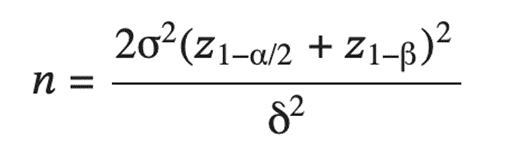

𝑛: sample size di tiap kelompok

σ: standar deviasi dari outcome variable

δ: peningkatan outcome variable yang diinginkan

𝑧1−α/2: tingkat statistical significance yang diinginkan

𝑧1−β: tingkat power yang diinginkan

#### Penentuan Asumsi:
##### standar deviasi (σ)
Standar deviasi diasumsikan sebesar 4% (dilihat dari data historis)
##### Significant level (α)
Significant value yang umum digunakan untuk penelitian non medis (penelitian yang bukan menyangkut nyawa/ laboratorium) maka diasumsikan sebesar 5%.
##### Difference between control and treatment (δ)
Berdasarkan keputusan manajemen akan lebih profitable jika effect size meningkat sebesar 1%.
##### Power level (1 - β)
Power level akan mengikuti yang dianjurkan oleh berbagai literatur yaitu 80%.

In [1]:
from scipy import stats
# Given

delta = 0.01        # Peningkatan conversion rate yang diinginkan
alpha = 0.05        # significance level
power = 0.8         # power
std_dev = 0.04      # variance of population (assumed / approximated)

# menghitung beta
beta = 1 - power

# menghitung nilai z 
z_alpha = stats.norm.ppf(1 - alpha/2)
z_beta = stats.norm.ppf(1 - beta)

# menghitung jumlah sample size
n = 2 * (std_dev**2) * ((z_alpha+z_beta)**2) / (delta**2)

print(f'Jumlah minimum sample yang dibutuhkan per kelompok varian adalah {n:.0f} sample')

Jumlah minimum sample yang dibutuhkan per kelompok varian adalah 251 sample


#### Time Span of Experiment
Eksperimen dilakukan selama tujuh hari, kemudian kita ambil data terhadap orang-orang yang terekspos iklan statis maupun iklan interaktif secara random sesuai dengan kebutuhan sampel. Kemudian dilakukan pengukuran dengan melihat Convert Rate dari user target tersebut.

### f. Running Experiment and Obtaining Data
Karena tidak dapat mengambil data secara langsung, maka data berikut diasumsikan menjadi data eksperimen.

In [36]:
# load packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
from tabulate import tabulate
from scipy.stats import chisquare
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import confint_proportions_2indep

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import dataset
data = pd.read_csv("AdSmartABdata.csv")
data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [4]:
# overview data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


In [5]:
# dimensi data
data.shape

(8077, 9)

In [6]:
# Rentang waktu eksperimen
data['date'].unique()

array(['2020-07-10', '2020-07-07', '2020-07-05', '2020-07-03',
       '2020-07-09', '2020-07-04', '2020-07-06', '2020-07-08'],
      dtype=object)

#### Mengecek data yang tidak merespon kuesioner
User dapat memilih untuk tidak menjawab 'Yes' atau 'No' ketika diperlihatkan kuesioner melalui advertisement. Karena eksperimen ini ingin melihat conversion rate, kita perlu menghapus observasi non-respon tersebut.

In [7]:
# cek data non-response
data_noresp = data[(data['yes'] == 0) & (data['no'] == 0)]
data_noresp
     

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
5,0027ce48-d3c6-4935-bb12-dfb5d5627857,control,2020-07-03,15,Samsung SM-G960F,6,Facebook,0,0
...,...,...,...,...,...,...,...,...,...
8072,ffea24ec-cec1-43fb-b1d1-8f93828c2be2,exposed,2020-07-05,7,Generic Smartphone,6,Chrome Mobile,0,0
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,2020-07-04,9,Generic Smartphone,6,Chrome Mobile,0,0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,exposed,2020-07-05,15,Samsung SM-A515F,6,Samsung Internet,0,0


In [8]:
# hilangkan data non-response 
new_data = data.drop(data_noresp.index)
new_data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0,1
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0
27,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,1


In [9]:
# dimensi data baru
new_data.shape

(1243, 9)

In [10]:
# melihat jumlah exposed dan control terbaru
new_data['experiment'].value_counts()

exposed    657
control    586
Name: experiment, dtype: int64

#### Mengambil sample

In [11]:
# mengambil sample control
sample_control = new_data[new_data["experiment"] == "control"]
sample_control = sample_control.sample(n = 251, random_state = 1) 
sample_control

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
7166,e3d9dd45-d1b7-4502-ab4a-d7f9f3a1c272,control,2020-07-08,19,Samsung SM-G960F,6,Chrome Mobile WebView,0,1
3374,6d0b7da0-7798-4b70-88c2-f94e5ab65cb6,control,2020-07-10,4,Generic Smartphone,6,Chrome Mobile,0,1
362,0b0344c4-b114-4705-ad68-6662f0d3bedc,control,2020-07-03,15,LG-$2,6,Chrome Mobile,1,0
6413,cb7d4819-501d-471c-ad2b-f4f945eb411e,control,2020-07-09,19,Samsung SM-G960F,6,Samsung Internet,1,0
3574,735d2323-b1f5-4fb8-9893-96a00e3a4e0f,control,2020-07-05,4,Samsung SM-G975F,6,Chrome Mobile WebView,1,0
...,...,...,...,...,...,...,...,...,...
7808,f79d0a9c-3d11-4145-aa4d-74bfb4dbc399,control,2020-07-06,3,Samsung SM-A105FN,6,Samsung Internet,1,0
5869,b9bb4710-4bde-43a7-ac9b-951f7a8d6e95,control,2020-07-07,13,Generic Smartphone,6,Chrome Mobile,1,0
4112,841b275a-7749-4182-bf5e-ef2720adee08,control,2020-07-03,15,Samsung SM-A515F,6,Chrome Mobile WebView,0,1
7670,f2ba9aee-4c90-41c1-85b8-340611a851c9,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,1,0


In [12]:
# mengambil sample treatment
sample_treatment = new_data[new_data["experiment"] == "exposed"]
sample_treatment = sample_treatment.sample(n = 251, random_state = 1)
sample_treatment

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
6025,bf518047-40e7-44e0-a653-16fb004dacab,exposed,2020-07-09,9,Generic Smartphone,6,Chrome Mobile,0,1
7470,ec77e672-dc3d-47ed-9fbb-f9f2a2d71ab7,exposed,2020-07-05,9,Generic Smartphone,6,Chrome Mobile,0,1
8059,ffa08ff9-a132-4051-aef5-01a9c79367bc,exposed,2020-07-05,21,Generic Smartphone,6,Chrome Mobile,1,0
4071,82a14bc9-b578-4f25-9bef-137c3136a094,exposed,2020-07-03,9,Generic Smartphone,6,Chrome Mobile,0,1
3119,64f4838d-5f0d-49a1-be79-f261ec4d8ddd,exposed,2020-07-04,17,Generic Smartphone,6,Chrome Mobile,0,1
...,...,...,...,...,...,...,...,...,...
7610,f0e7fb7e-636a-492a-9666-0a6db8b2fa03,exposed,2020-07-09,9,Generic Smartphone,6,Chrome Mobile,1,0
6671,d3bad2f2-1619-413b-96c9-460ca19c4ab3,exposed,2020-07-09,0,Samsung SM-A310F,6,Samsung Internet,1,0
2183,4796d66c-1849-4a31-bb38-75b0d41d566c,exposed,2020-07-06,9,Generic Smartphone,6,Chrome Mobile,0,1
5245,a67c0609-3e55-4aec-9078-e9bd2c528ce8,exposed,2020-07-07,11,Generic Smartphone,6,Chrome Mobile,0,1


In [13]:
# menggabungkan dataframe control dan treatment
sample = sample_control.append(sample_treatment, ignore_index = True)
sample

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,e3d9dd45-d1b7-4502-ab4a-d7f9f3a1c272,control,2020-07-08,19,Samsung SM-G960F,6,Chrome Mobile WebView,0,1
1,6d0b7da0-7798-4b70-88c2-f94e5ab65cb6,control,2020-07-10,4,Generic Smartphone,6,Chrome Mobile,0,1
2,0b0344c4-b114-4705-ad68-6662f0d3bedc,control,2020-07-03,15,LG-$2,6,Chrome Mobile,1,0
3,cb7d4819-501d-471c-ad2b-f4f945eb411e,control,2020-07-09,19,Samsung SM-G960F,6,Samsung Internet,1,0
4,735d2323-b1f5-4fb8-9893-96a00e3a4e0f,control,2020-07-05,4,Samsung SM-G975F,6,Chrome Mobile WebView,1,0
...,...,...,...,...,...,...,...,...,...
497,f0e7fb7e-636a-492a-9666-0a6db8b2fa03,exposed,2020-07-09,9,Generic Smartphone,6,Chrome Mobile,1,0
498,d3bad2f2-1619-413b-96c9-460ca19c4ab3,exposed,2020-07-09,0,Samsung SM-A310F,6,Samsung Internet,1,0
499,4796d66c-1849-4a31-bb38-75b0d41d566c,exposed,2020-07-06,9,Generic Smartphone,6,Chrome Mobile,0,1
500,a67c0609-3e55-4aec-9078-e9bd2c528ce8,exposed,2020-07-07,11,Generic Smartphone,6,Chrome Mobile,0,1


#### Memastikan Kualitas Data

In [14]:
# cek missing value
sample.isna().sum()

auction_id     0
experiment     0
date           0
hour           0
device_make    0
platform_os    0
browser        0
yes            0
no             0
dtype: int64

In [15]:
# cek data duplikat
sample.duplicated('auction_id').sum()

0

In [16]:
# mengubah kolom 'yes' menjadi 'convert': Bernilai 1 jika user memilih tombol 'yes',bernilai 0 apabila user memilih tombol 'no'
sample.drop('no', axis = 1, inplace = True)
sample.rename(columns = {'yes':'converted'}, inplace = True)
sample
     

,auction_id,experiment,date,hour,device_make,platform_os,browser,converted
0,e3d9dd45-d1b7-4502-ab4a-d7f9f3a1c272,control,2020-07-08,19,Samsung SM-G960F,6,Chrome Mobile WebView,0
1,6d0b7da0-7798-4b70-88c2-f94e5ab65cb6,control,2020-07-10,4,Generic Smartphone,6,Chrome Mobile,0
2,0b0344c4-b114-4705-ad68-6662f0d3bedc,control,2020-07-03,15,LG-$2,6,Chrome Mobile,1
3,cb7d4819-501d-471c-ad2b-f4f945eb411e,control,2020-07-09,19,Samsung SM-G960F,6,Samsung Internet,1
4,735d2323-b1f5-4fb8-9893-96a00e3a4e0f,control,2020-07-05,4,Samsung SM-G975F,6,Chrome Mobile WebView,1
...,...,...,...,...,...,...,...,...
497,f0e7fb7e-636a-492a-9666-0a6db8b2fa03,exposed,2020-07-09,9,Generic Smartphone,6,Chrome Mobile,1
498,d3bad2f2-1619-413b-96c9-460ca19c4ab3,exposed,2020-07-09,0,Samsung SM-A310F,6,Samsung Internet,1
499,4796d66c-1849-4a31-bb38-75b0d41d566c,exposed,2020-07-06,9,Generic Smartphone,6,Chrome Mobile,0
500,a67c0609-3e55-4aec-9078-e9bd2c528ce8,exposed,2020-07-07,11,Generic Smartphone,6,Chrome Mobile,0


#### Sample Ratio Missmatch

In [17]:
# membuat data control
data_control = sample[sample['experiment'] == 'control']
data_control.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,converted
0,e3d9dd45-d1b7-4502-ab4a-d7f9f3a1c272,control,2020-07-08,19,Samsung SM-G960F,6,Chrome Mobile WebView,0
1,6d0b7da0-7798-4b70-88c2-f94e5ab65cb6,control,2020-07-10,4,Generic Smartphone,6,Chrome Mobile,0
2,0b0344c4-b114-4705-ad68-6662f0d3bedc,control,2020-07-03,15,LG-$2,6,Chrome Mobile,1
3,cb7d4819-501d-471c-ad2b-f4f945eb411e,control,2020-07-09,19,Samsung SM-G960F,6,Samsung Internet,1
4,735d2323-b1f5-4fb8-9893-96a00e3a4e0f,control,2020-07-05,4,Samsung SM-G975F,6,Chrome Mobile WebView,1


In [18]:
# membuat data treatment
data_treatment = sample[sample['experiment'] == 'exposed']
data_treatment.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,converted
251,bf518047-40e7-44e0-a653-16fb004dacab,exposed,2020-07-09,9,Generic Smartphone,6,Chrome Mobile,0
252,ec77e672-dc3d-47ed-9fbb-f9f2a2d71ab7,exposed,2020-07-05,9,Generic Smartphone,6,Chrome Mobile,0
253,ffa08ff9-a132-4051-aef5-01a9c79367bc,exposed,2020-07-05,21,Generic Smartphone,6,Chrome Mobile,1
254,82a14bc9-b578-4f25-9bef-137c3136a094,exposed,2020-07-03,9,Generic Smartphone,6,Chrome Mobile,0
255,64f4838d-5f0d-49a1-be79-f261ec4d8ddd,exposed,2020-07-04,17,Generic Smartphone,6,Chrome Mobile,0


In [19]:
# menghitung jumlah user di control dan treatment group
n_control = data_control.shape[0]
n_treatment = data_treatment.shape[0]

print(f'Jumlah user di kelompok control    : {n_control} users')
print(f'Jumlah user di kelompok treatment  : {n_treatment} users')

Jumlah user di kelompok control    : 251 users
Jumlah user di kelompok treatment  : 251 users


In [20]:
# percentase di tiap grup
n_total = sample.shape[0]
persen_control = n_control/n_total * 100
persen_treat = n_treatment/n_total * 100

print(f"Persentase varian control   : {persen_control:.2f}%")
print(f"Persentase varian treatment : {persen_treat:.2f}%")

Persentase varian control   : 50.00%
Persentase varian treatment : 50.00%


In [21]:
# membuat variabel observed dan expected value
observed = [ n_control, n_treatment ]
total_traffic= sum(observed)
expected = [ total_traffic/2, total_traffic/2 ]

In [22]:
# menghitung chi-square statistics
chi = chisquare(observed, f_exp=expected)
print(chi)

Power_divergenceResult(statistic=0.0, pvalue=1.0)


In [23]:
# perbandingan chi-square statistics dengan critical value
# kita harus menghitung critical value terlebih dahulu

alpha = 0.01
df=(2-1)*(2-1)  

chi_critical = scipy.stats.chi2.ppf(1 - alpha, df)
print(f"Critical value: {chi_critical:.3f}")

Critical value: 6.635


In [24]:
# Membuat keputusan dari chi-square statistics dan critical value
if chi[0] > chi_critical:
  print("Tolak H0 : Adanya kemungkinan SRM.")
else:
  print("Gagal menolak H0 : Tidak ada SRM")

Gagal menolak H0 : Tidak ada SRM


In [25]:
# Comparison of P-Value with alpha.
if chi[1] < 0.01:
  print("Tolak H0 : Adanya kemungkinan SRM.")
else:
  print("Gagal menolak H0 : Tidak ada SRM")

Gagal menolak H0 : Tidak ada SRM


Berdasarkan pengecekan kualitas data dan SRM, data yang digunakan pada eksperimen ini sudah bersih dan siap digunakan untuk dianalisis.

### g. Analyzing and Interpreting the Data

In [29]:
# banyak user convert di group control

# cari data group control yang convert
data_control_convert = data_control[data_control["converted"] == 1]

# hitung banyak data yang convert
n_control_convert = data_control_convert.shape[0]

n_control_convert

124

In [30]:
# banyak user convert di group treatment

# cari data group treatment yang convert
data_treatment_convert = data_treatment[data_treatment["converted"] == 1]

# hitung banyak data yang convert
n_treatment_convert = data_treatment_convert.shape[0]

n_treatment_convert

112

In [31]:
# conversion rate user control
cr_control = n_control_convert / n_control
cr_control

0.4940239043824701

In [32]:
# conversion rate user treatment
cr_treatment = n_treatment_convert / n_treatment
cr_treatment

0.44621513944223107

In [38]:
# membuat tabel agar lebih mudah dibandingkan antar variant

data = {
    'Group': ['Control', 'Treatment'],
    'Jumlah User': [251, 251],
    'Jumlah Konversi': [n_control_convert, n_treatment_convert],
    'Conversion Rate': [cr_control, cr_treatment]
}

df = pd.DataFrame(data)
table = tabulate(df, headers='keys', tablefmt='grid', numalign="center", stralign="center")
print(table)


+----+-----------+---------------+-------------------+-------------------+
|    |   Group   |  Jumlah User  |  Jumlah Konversi  |  Conversion Rate  |
+====+===========+===============+===================+===================+
| 0  |  Control  |      251      |        124        |     0.494024      |
+----+-----------+---------------+-------------------+-------------------+
| 1  | Treatment |      251      |        112        |     0.446215      |
+----+-----------+---------------+-------------------+-------------------+


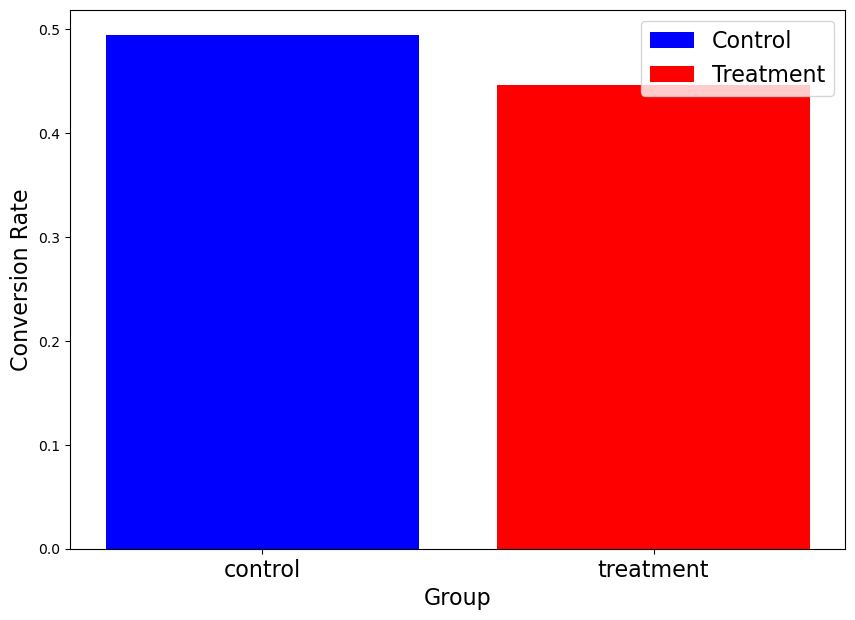

In [42]:
# membuat visualisasi
# visualisasi perbandingan conversion rate tiap varian
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

# buat plot
ax.bar("control", cr_control, color="blue", label="Control")
ax.bar("treatment", cr_treatment, color="red", label="Treatment")

# styling plot
ax.set_ylabel("Conversion Rate", fontsize=16)
ax.set_xlabel("Group", fontsize=16)
ax.set_xticklabels(labels=["control", "treatment"], fontsize=16)
ax.legend(fontsize=16)
plt.show()

Conversion rate dari variant control terlihat lebih tinggi dari variant treatment. Namun kita harus melakukan uji statistik untuk membuktikan perbedaan antar kedua variant signifikan secara statistik.

#### Uji Statistik
Kita definisikan Null hypothesis (H0)) dan Alternative hypothesis (H1)

𝐻0: CR_interactive ≤ CR_static

𝐻1: CR_interactive > CR_static

In [43]:
# buat count convert & total observation
# variabel total observation sudah kita buat dengan nama 'observed'
count_convert = [n_treatment_convert,n_control_convert]

In [44]:
# buat alternative
alternative_option = "larger"

In [45]:
# panggil fungsi
z_stat, p_value = proportions_ztest(count = count_convert,
                                    nobs = observed,
                                    alternative = alternative_option)

print(f"Z stats : {z_stat:.4f}")
print(f"P-value : {p_value:.4f}")

Z stats : -1.0731
P-value : 0.8584


In [46]:
# hitung selisih cr treatment dengan cr control
cr_treatment - cr_control

-0.04780876494023906

In [47]:
# menghitung relative effect yang menunjukkan seberapa besar persentase peningkatan atau penurunan conversion rate treatment dibandingkan control
relative_effect = (cr_treatment - cr_control)/cr_control * 100

print(f"relative effect = {relative_effect:.3} %")

relative effect = -9.68 %


#### Menyimpulkan hasil Uji statistik

In [48]:
# dari p-value
alpha = 0.05        # confidence level yang kita set

# buat decision berdasarkan p_value dan alpha
if p_value < alpha:
    print("Tolak H0")
else:
    print("Gagal menolak H0")

Gagal menolak H0


In [49]:
# Z critical adalah z-value saat alpha
z_critical = stats.norm.ppf(1 - alpha)

z_critical

1.6448536269514722

In [50]:
# Dari z-statistics
# Buat decision berdasarkan z_critical dan alpha
if z_stat > z_critical:
    print("Tolak H0")
else:
    print("Gagal menolak H0")


Gagal menolak H0


Berdasarkan hasil uji statistik didapatkan:

p-value (0.8584) > alpha (0.05) → Gagal menolak H0
z-statistics (-1.0731) < z tabel (1.644) → Gagal menolak H0

Dari hal tersebut dapat disimpulkan bahwa interactive ad kurang dari atau sama dengan static ad. Dengan kata lain, interactive ad tidak meningkatkan conversion rate

#### Menghitung Confidence Interval

In [51]:
# menghitung confidence interval
confidence_interval = confint_proportions_2indep(count1 = n_treatment_convert, nobs1 = n_treatment,
                                                 count2 = n_control_convert, nobs2 = n_control, 
                                                 compare='diff', alpha=0.05)
print(confidence_interval)

(-0.13386823518539348, 0.039266242474423535)


Berdasarkan hasil perhitungan confidence interval, kita yakin 95% bahwa selisih user yang convert pada treatment variant dan control variant terletak antara -0.13 dan 0.039.

Dengan kata lain penerapan interactive ads dapat menurunkan conversion rate sebesar -0.13 atau meningkatkan conversion rate sebesar 0.039

### h. Conclusion and Recommendation

1. Eksperimen ini belum memiliki cukup bukti untuk mengatakan bahwa advertisement dengan interaktif ad dapat meningkatkan conversion rate. Hal ini didapat dari hasil uji signifikansi menunjukkan hasil yang tidak signifikan baik melihat perbandingan z-statistik dengan z-critical ataupun p-value dengan alpha.

2. Besaran penurunan yang diestimasi menggunakan confidence interval kita yakin 95% bahwa selisih user yang convert pada treatment variant dan control variant terletak antara -0.13  dan 0.039.

3. Penggunaan advertisement baru (interactive ad) dikhawatirkan dapat meningkatkan loading time (latency) atau error per page yang dapat mengganggu conversion rate dalam mengisi kuesioner.

4. Eksperimen selanjutnya dapat melakukan A/B Testing lebih mendetail seperti contohnya melakukan A/B Testing berdasarkan browser atau jenis device untuk melihat kemungkinan penerapan interactive ads pada browser atau jenis device tertentu.

5. Eksperimen juga dapat dilanjutkan dengan melakukan A/B testing berdasarkan waktu atau jam-jam tertentu untuk melihat kemungkinan pengaruh waktu atau jam terhadap pengisian user. Karena mungkin tidak semua user punya waktu senggang yang sama.